## Notebook to test different test

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax
import jax.scipy as jscipy
import optimization_SPDC as opt
import get_initialization_cond as init
import scipy
import numpy as np

In [2]:
# Initialize waveguide parameters
vp = 0.1
l = 1
wi = -10
wf = 10
# negative Np wuch that gamma is purely imaginary
Np = -0.1+0*1.j
N = 401
method = "hermite"
gauss_amp = 1
gauss_width = 0.4
gauss_phase = 0

In [3]:
# Get initial pump and SU(1,1) algebra elements
alpha, G, H = init.get_constants(vp, l, wi, wf, Np, N = N)
pump = init.get_initialization_array([0, gauss_amp, gauss_width, gauss_phase], vp, l, wi, wf, Np, method = method, N=N)

In [4]:
# Build submatrices of U
F = alpha*opt.moving_window(pump, N)[:-1]
Q = jnp.block([[G, F], [-jnp.conj(F).T, -jnp.conj(H).T]])
U = jax.scipy.linalg.expm(1j*Q*l)
N = len(U)
U_ss = U[:N//2, :N//2]
U_is = U[:N//2, N//2:N]
U_si = U[N//2:N, :N//2]
U_ii = U[N//2:N,N//2:N]

In [5]:
# Tests to see if matrices are well built
test_phase_match_cond = jnp.allclose(G, -H)
V_matrix_verif = jnp.allclose(U_ss + U_si, U_is + U_ii, rtol=0.01)
W_matrix_verif = jnp.allclose(U_ss - U_si, U_ii - U_is, rtol=0.01)
# Commutation tests (sum is used because even though the difference is small, allclose still does not recognize them as similar matrices...)
# The absolute value of these matrices can even be plotted with matshow and it would show mostly noise
# matrix exponential can introduce a lot of noise because of the algorithm of powers used
commutation_ai_as = sum(sum(jnp.abs((U_ss@jnp.conj(U_si).T- U_is@jnp.conj(U_ii).T))))
commutation_as_as_dagger = sum(sum(jnp.abs((U_ss@jnp.conj(U_ss).T - U_si@jnp.conj(U_si).T - jnp.eye(len(U_ss))))))

In [6]:
# Get V and W, propagators of pseudo-quadratures in frequency
V = U_ss + U_si
W = U_ss - U_si
# Test where commutation relations of U_ss/U_si/U_is/U_ii are made with V/W
commutation_ai_as = sum(sum(np.abs(V@jnp.conj(W).T-W@jnp.conj(V).T)))
commutation_as_as_dagger = sum(sum(np.abs(V@jnp.conj(W).T-jnp.eye(len(U_ss)))))

In [7]:
# See commutation relation VVdagger, WWdagger
commutation_V_dagger_V = sum(sum(jnp.abs(V@jnp.conj(V).T - jnp.conj(V).T@V)))
commutation_W_dagger_W = sum(sum(jnp.abs(W@jnp.conj(W).T - jnp.conj(W).T@W)))
# See commutation relation V_dagger V and W_dagger W


In [8]:
# Objective function in V/W (4*Tr(N_U) = Tr(N), parfaitement comme prevu theoriquement)
N = V@jnp.conj(V).T + W@jnp.conj(W).T - 2*jnp.eye(len(V))
N_U = U_si@jnp.conj(U_si).T

In [9]:
(jnp.trace(U_is@jnp.conj(U_is).T)**2)/jnp.trace(U_is@jnp.conj(U_is).T@U_is@jnp.conj(U_is).T)

DeviceArray(1.2246512-1.5387962e-09j, dtype=complex64)

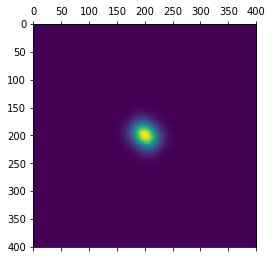

In [44]:
plt.matshow(jnp.abs(N))

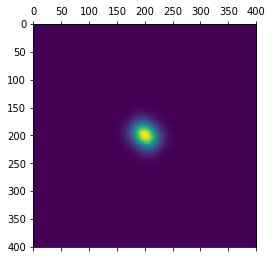

In [45]:
plt.matshow(jnp.abs(N_U))